In [1]:
import pandas as pd

# Load observation dataset
df = pd.read_csv("/Users/gayathrigandham/Documents/fdsproject/mallar3_presence_full.csv")

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
    

In [3]:
df.head()

,loc_id,month,day,year,latitude_x,longitude_x,subnational1_code,entry_technique,sub_id,obs_id,...,squirrels,cats,dogs,humans,housing_density,fed_yr_round,population_atleast,count_area_size_sq_m_atleast,supp_food,mallar3
0,L100032,1,1,2022,45.132361,-93.130328,US-MN,PointMaker1.0_2,S99980633,OBS1309193551,...,1.0,0.0,0.0,1.0,2.0,1.0,5001.0,100.01,1.0,0
1,L100032,1,2,2021,45.132361,-93.130328,US-MN,PointMaker1.0_2,S78619678,OBS1043705000,...,1.0,0.0,0.0,1.0,2.0,1.0,5001.0,100.01,1.0,0
2,L100032,1,6,2024,45.132361,-93.130328,US-MN,PointMaker1.0_2,S158543030,OBS1920263354,...,1.0,0.0,0.0,1.0,2.0,1.0,5001.0,100.01,1.0,0
3,L100032,1,7,2023,45.132361,-93.130328,US-MN,PointMaker1.0_2,S127597341,OBS1622818010,...,1.0,0.0,0.0,1.0,2.0,1.0,5001.0,100.01,1.0,0
4,L100032,1,9,2021,45.132361,-93.130328,US-MN,PointMaker1.0_2,S79048895,OBS1049040305,...,1.0,0.0,0.0,1.0,2.0,1.0,5001.0,100.01,1.0,0


In [4]:
# Convert all column names to lowercase to avoid KeyError issues
df.columns = df.columns.str.lower()

# Drop identifiers and target columns
drop_cols = ["loc_id", "subnational1_code", "entry_technique", "latitude_y","longitude_y",
             "sub_id", "obs_id", "year", "proj_period_id", "species_code", "how_many",'day1_am', 'day1_pm', 'day2_am', 'day2_pm', 'effort_hrs_atleast','dcid_shrbs_atleast','housing_density','mallar3']

# Select features (X) and target (y)
X = df.drop(columns=drop_cols)
y = df["mallar3"]

print(X.shape)
print(y.shape)

# Fill missing numeric values with 0
X = X.fillna(0)


(89935, 41)
(89935,)


In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=20)
X_new = selector.fit_transform(X, y)

mask = selector.get_support()

# Retrieve selected feature names
selected_features = X.columns[mask]

print("Selected feature names:", list(selected_features))
print("Scores:", selector.scores_[mask])


Selected feature names: ['latitude_x', 'longitude_x', 'yard_type_landsca', 'yard_type_woods', 'hab_dcid_woods', 'hab_mixed_woods', 'hab_park', 'hab_water_fresh', 'hab_residential', 'evgr_trees_atleast', 'evgr_shrbs_atleast', 'dcid_trees_atleast', 'bird_baths_atleast', 'nearby_feeders', 'squirrels', 'dogs', 'humans', 'fed_yr_round', 'count_area_size_sq_m_atleast', 'supp_food']
Scores: [0.0422973  0.04259195 0.01579536 0.01809422 0.01584315 0.01923211
 0.00657547 0.01989069 0.02534368 0.00893201 0.00791107 0.008947
 0.01566352 0.00668236 0.01539855 0.01817128 0.0148086  0.01629671
 0.0150045  0.0239688 ]


In [6]:
X = X[list(selected_features)]
print(X)

       latitude_x  longitude_x  yard_type_landsca  yard_type_woods  \
0       45.132361   -93.130328                1.0              1.0   
1       45.132361   -93.130328                1.0              1.0   
2       45.132361   -93.130328                1.0              1.0   
3       45.132361   -93.130328                1.0              1.0   
4       45.132361   -93.130328                1.0              1.0   
...           ...          ...                ...              ...   
89930   41.647811   -85.941496                1.0              1.0   
89931   41.647811   -85.941496                1.0              1.0   
89932   41.647811   -85.941496                1.0              1.0   
89933   41.647811   -85.941496                1.0              1.0   
89934   41.647811   -85.941496                1.0              1.0   

       hab_dcid_woods  hab_mixed_woods  hab_park  hab_water_fresh  \
0                 1.0              1.0       0.0              1.0   
1                 1.0

In [7]:
# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


In [10]:
logreg = LogisticRegression(max_iter=1000,random_state=42)
logreg.fit(X_train_resampled, y_train_resampled)
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)[:,1]


In [11]:
#import pandas as pd

def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_prob))
    print(classification_report(y_true, y_pred))
    
    # Confusion matrix with class labels
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["Actual: absent", "Actual: present"],
        columns=["Predicted: absent", "Predicted: present"]
    )
    
    print("Confusion Matrix:\n")
    print(cm_df)
    print("\n")

evaluate_model(y_test, y_pred_logreg, y_prob_logreg, "Logistic Regression")


--- Logistic Regression ---
Accuracy: 0.667760048924223
ROC AUC: 0.7478981551717926
              precision    recall  f1-score   support

           0       0.99      0.67      0.80     17743
           1       0.03      0.73      0.06       244

    accuracy                           0.67     17987
   macro avg       0.51      0.70      0.43     17987
weighted avg       0.98      0.67      0.79     17987

Confusion Matrix:

                 Predicted: absent  Predicted: present
Actual: absent               11834                5909
Actual: present                 67                 177




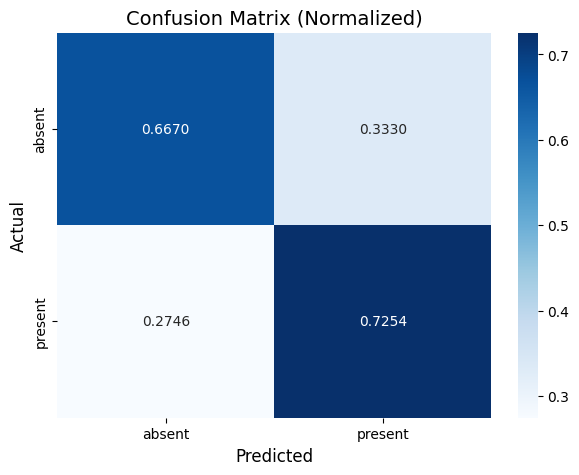

Raw Confusion Matrix:

[[11834  5909]
 [   67   177]]


In [12]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize row-wise

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_norm, annot=True, fmt=".4f", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title("Confusion Matrix (Normalized)", fontsize=14)
    plt.show()

    # Also print the raw counts
    print("Raw Confusion Matrix:\n")
    print(cm)

# Example usage:
plot_confusion_matrix(y_test, y_pred_logreg, ["absent", "present"])


In [13]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]


In [14]:
def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_prob))
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\n") 
    # Confusion matrix with class labels
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["Actual: absent", "Actual: present"],
        columns=["Predicted: absent", "Predicted: present"]
    )
    
    print("Confusion Matrix:\n")
    print(cm_df)
    print("\n")

evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")

--- Random Forest ---
Accuracy: 0.9662534052371157
ROC AUC: 0.9413076087267848
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     17743
           1       0.26      0.83      0.40       244

    accuracy                           0.97     17987
   macro avg       0.63      0.90      0.69     17987
weighted avg       0.99      0.97      0.97     17987

Confusion Matrix:
 [[17178   565]
 [   42   202]]


Confusion Matrix:

                 Predicted: absent  Predicted: present
Actual: absent               17178                 565
Actual: present                 42                 202




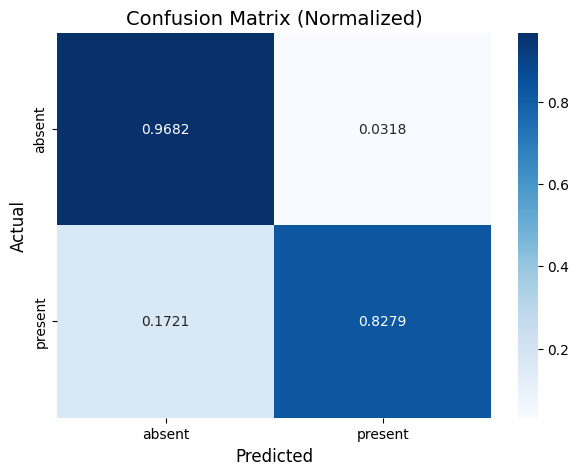

Raw Confusion Matrix:

[[17178   565]
 [   42   202]]


In [15]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize row-wise

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_norm, annot=True, fmt=".4f", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title("Confusion Matrix (Normalized)", fontsize=14)
    plt.show()

    # Also print the raw counts
    print("Raw Confusion Matrix:\n")
    print(cm)

# Example usage:
plot_confusion_matrix(y_test, y_pred_rf, ["absent", "present"])

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

knn_scaled = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

knn_scaled.fit(X_train_resampled, y_train_resampled)
y_pred_knn = knn_scaled.predict(X_test)
y_prob_knn = knn_scaled.predict_proba(X_test)[:, 1]

In [17]:
def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_prob))
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\n") 
    # Confusion matrix with class labels
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["Actual: absent", "Actual: present"],
        columns=["Predicted: absent", "Predicted: present"]
    )
    
    print("Confusion Matrix:\n")
    print(cm_df)
    print("\n")

evaluate_model(y_test, y_pred_knn, y_prob_knn, "knn")

--- knn ---
Accuracy: 0.988102518485573
ROC AUC: 0.8440519835575887
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17743
           1       0.60      0.38      0.47       244

    accuracy                           0.99     17987
   macro avg       0.79      0.69      0.73     17987
weighted avg       0.99      0.99      0.99     17987

Confusion Matrix:
 [[17680    63]
 [  151    93]]


Confusion Matrix:

                 Predicted: absent  Predicted: present
Actual: absent               17680                  63
Actual: present                151                  93




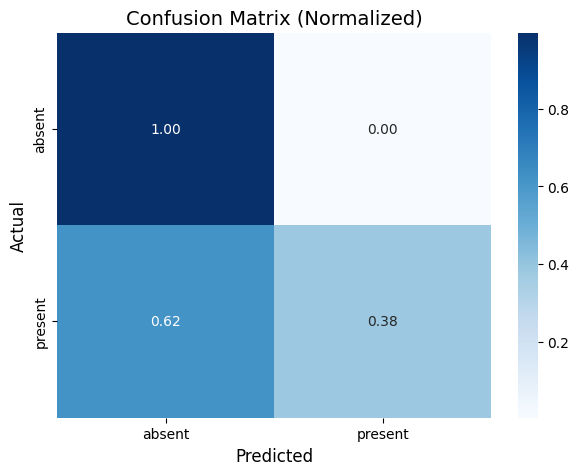

Raw Confusion Matrix:

[[17680    63]
 [  151    93]]


In [18]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize row-wise

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title("Confusion Matrix (Normalized)", fontsize=14)
    plt.show()

    # Also print the raw counts
    print("Raw Confusion Matrix:\n")
    print(cm)

# Example usage:
plot_confusion_matrix(y_test, y_pred_knn, ["absent", "present"])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt


dt = DecisionTreeClassifier(
    random_state=72,
    max_depth=None,         
    min_samples_split=2,     
    min_samples_leaf=1,      
    class_weight=None        
)


dt.fit(X_train_resampled, y_train_resampled)


y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]  

evaluate_model(y_test, y_pred_dt, y_prob_dt, "Decision Tree")

thresholds = np.arange(0.0, 1.0, step=0.01)
recall_scores = [recall_score(y_test, y_prob_dt > t) for t in thresholds]
precis_scores = [precision_score(y_test, y_prob_dt > t) for t in thresholds]

evaluate_model(y_test, y_pred_dt, y_prob_dt, "Decision Tree")


--- Decision Tree ---
Accuracy: 0.9660866181130817
ROC AUC: 0.9398544842898099
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     17743
           1       0.26      0.83      0.40       244

    accuracy                           0.97     17987
   macro avg       0.63      0.90      0.69     17987
weighted avg       0.99      0.97      0.97     17987

Confusion Matrix:
 [[17175   568]
 [   42   202]]


Confusion Matrix:

                 Predicted: absent  Predicted: present
Actual: absent               17175                 568
Actual: present                 42                 202


--- Decision Tree ---
Accuracy: 0.9660866181130817
ROC AUC: 0.9398544842898099
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     17743
           1       0.26      0.83      0.40       244

    accuracy                           0.97     17987
   macro avg       0.63      0.90      0.69     17987
weigh

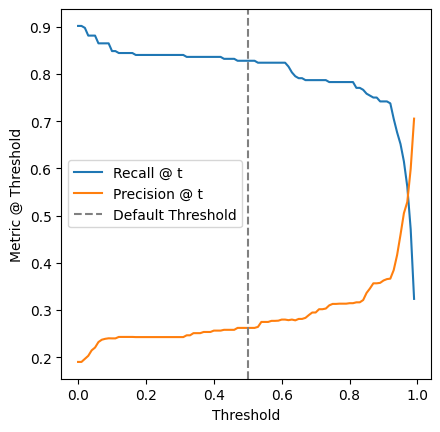

In [20]:
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, recall_scores, label="Recall @ t")
ax.plot(thresholds, precis_scores, label="Precision @ t")
ax.axvline(0.5, c="gray", linestyle="--", label="Default Threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric @ Threshold")
ax.set_box_aspect(1)
ax.legend()
plt.show()


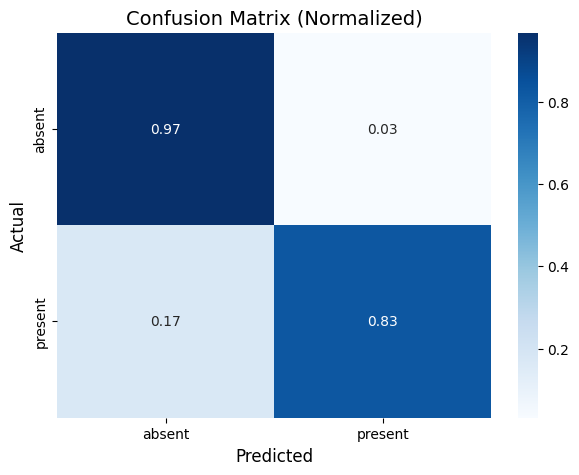

Raw Confusion Matrix:

[[17175   568]
 [   42   202]]


In [21]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize row-wise

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title("Confusion Matrix (Normalized)", fontsize=14)
    plt.show()

    # Also print the raw counts
    print("Raw Confusion Matrix:\n")
    print(cm)

plot_confusion_matrix(y_test, y_pred_dt, ["absent", "present"])

                         feature  importance
0                     latitude_x    0.316910
1                    longitude_x    0.206127
7                hab_water_fresh    0.095386
9             evgr_trees_atleast    0.058425
11            dcid_trees_atleast    0.056119
15                          dogs    0.037922
10            evgr_shrbs_atleast    0.037774
18  count_area_size_sq_m_atleast    0.034942
5                hab_mixed_woods    0.028057
12            bird_baths_atleast    0.027417
6                       hab_park    0.026686
13                nearby_feeders    0.020543
4                 hab_dcid_woods    0.017446
3                yard_type_woods    0.014485
17                  fed_yr_round    0.006268
8                hab_residential    0.006262
16                        humans    0.003532
2              yard_type_landsca    0.002995
14                     squirrels    0.002703
19                     supp_food    0.000000


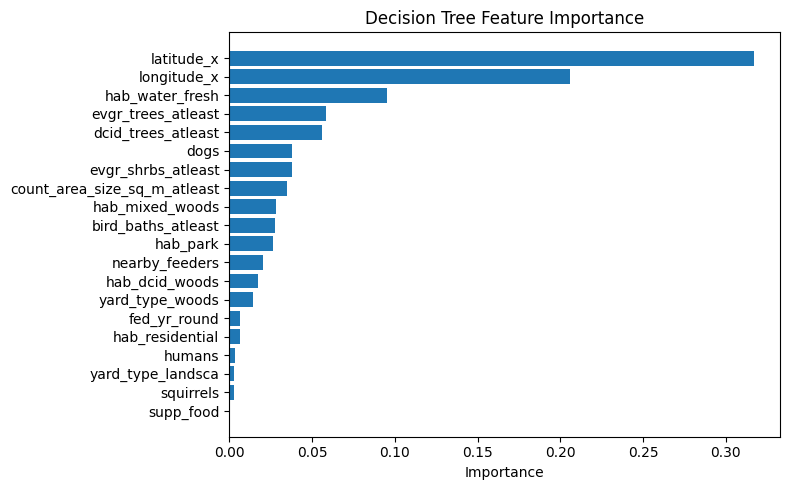

In [22]:
importances = dt.feature_importances_
feature_names = list(selected_features)

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feat_imp_df)

#plotting feature importance
top_n = 20 

top_features = feat_imp_df.head(top_n)

plt.figure(figsize=(8, 5))
plt.barh(top_features['feature'], top_features['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Decision Tree Feature Importance")
plt.tight_layout()
plt.show()
